# Core Features: Import

In [13]:
# libraries
import copy
import sys
import os
from typing import List
import time
import random
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np

import torch
import torch.nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, utils
from torchinfo import summary
from tqdm import tqdm

matplotlib.rcParams['figure.figsize'] = [18, 12]
%matplotlib inline

In [14]:
# code from this library - import the lines module
import loss_landscapes
import loss_landscapes.metrics
from loss_landscapes.model_interface.model_wrapper import ModelWrapper, wrap_model
from loss_landscapes.model_interface.model_parameters import ModelParameters, rand_u_like, rand_n_like, orthogonal_to
from loss_landscapes.contrib.functions import SimpleWarmupCaller, SimpleLossEvalCaller, log_refined_loss

In [15]:
sys.path.append("/global/u2/g/geshi/PyHessian")
from utils import * # get the dataset
from pyhessian import hessian # Hessian computation
from density_plot import get_esd_plot, density_generate # ESD plot

In [16]:
sys.path.append("/global/u2/g/geshi/Scientific_Segmentation/")
sys.path.append("/global/homes/g/geshi/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/cv2")
from pytorchUNetCRF.metrics import IOULoss, DiceLoss
from pytorchUNetCRF.models import SegmentationNet, CrfRnnNet
from pytorchUNetCRF.crfasrnn.params import DenseCRFParams
from pytorchUNetCRF.data_utils.input_pipeline import FiberSegDataset
from pytorchUNetCRF import test_UNet
from crfseg import CRF

## 1. Preliminary: Define Parameters

In [17]:
# model architecture hyperparameters
downward_params = {
    'in_channels': 3, 
    'emb_sizes': [64, 128, 256, 512], 
    'kernel_sizes': [3, 3, 3 ,3 ,3], 
    'paddings': [1, 1, 1, 1, 1], 
    'batch_norm_first': False,
}
upward_params = {
    'in_channels': [512, 1536, 768, 384, 192],
    'emb_sizes': [1024, 512, 256, 128, 64], 
    'out_channels': [1024, 512, 256, 128, 64],
    'kernel_sizes': [3, 3, 3, 3, 3], 
    'paddings': [1, 1, 1, 1, 1], 
    'batch_norm_first': False, 
    'bilinear': True,
}
output_params = {
    'in_channels': 64,
    'n_classes': 2,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
# Hyper-parameters
train_images = "/global/cfs/projectdirs/m636/Vis4ML/Fiber/Quarter/train/img/"
train_annotations = "/global/cfs/projectdirs/m636/Vis4ML/Fiber/Quarter/train/ann/"
val_images = "/global/cfs/projectdirs/m636/Vis4ML/Fiber/Quarter/val/img/"
val_annotations = "/global/cfs/projectdirs/m636/Vis4ML/Fiber/Quarter/val/ann/"
batch_size=16
classes = ('background', 'foreground')
n_classes = len(classes)
n_workers = 0
input_height = 288
input_width = 288
output_height = 288
output_width = 288
other_inputs_paths=None
preprocessing=None
read_image_type=1

In [19]:
# contour plot resolution
STEPS = 20
RANDOM = 'normal'
NORM = 'layer'
DIST = 0.005
MODEL_DIR = '/global/cfs/cdirs/m636/geshi/exp/non-crf/CrossEntropy/0_seed_243'
trained_on = MODEL_DIR.split('/')[-2]
seed = (int)(MODEL_DIR.split('/')[-1].split('_')[-1])
use_hessian = True

In [20]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [21]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    ])

target_transform = transforms.Compose([
    transforms.ToTensor(),
    ])

In [22]:
dataset = FiberSegDataset(train_images, train_annotations, n_classes, 
    input_height, input_width, output_height, output_width,
    transform=data_transform, target_transform = target_transform,
    other_inputs_paths=other_inputs_paths, preprocessing=preprocessing, 
    read_image_type=read_image_type, ignore_segs=False)

val_dataset = FiberSegDataset(val_images, val_annotations, n_classes, 
    input_height, input_width, output_height, output_width,
    transform=data_transform, target_transform = target_transform,
    other_inputs_paths=other_inputs_paths, preprocessing=preprocessing, 
    read_image_type=read_image_type, ignore_segs=False)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers)

## 2. Model construction and evaluation

In [23]:
x = torch.rand(1, 3, 288, 288)
model = SegmentationNet(downward_params, upward_params, output_params)
out = model(x)
print('output shape', out.shape)

output shape torch.Size([1, 2, 288, 288])


In [24]:
model = model.to(device)
model.eval()
# stores the initial point in parameter space
model_initial = copy.deepcopy(model)

In [25]:
# define the comparison function to sort
def srotFunc(e):
    return int(e.split('-')[0].split('iter')[1])

In [26]:
# define settings to try
try_models = []
for name in os.listdir(MODEL_DIR):
    if name.endswith('.pt'):
        try_models.append(name)
try_models.sort(key=srotFunc, reverse=True)
print(try_models)

['iter4096-08-14-2023-06:10:55.pt', 'iter2048-08-14-2023-05:35:00.pt', 'iter1024-08-14-2023-05:21:44.pt', 'iter512-08-14-2023-05:14:35.pt', 'iter256-08-14-2023-05:10:25.pt', 'iter128-08-14-2023-05:08:14.pt', 'iter64-08-14-2023-05:07:13.pt', 'iter32-08-14-2023-05:06:47.pt', 'iter16-08-14-2023-05:06:33.pt', 'iter8-08-14-2023-05:06:21.pt', 'iter4-08-14-2023-05:06:16.pt', 'iter2-08-14-2023-05:06:13.pt', 'iter1-08-14-2023-05:06:11.pt', 'iter0-08-14-2023-05:05:33.pt']


In [45]:
checkpoint = torch.load(os.path.join(MODEL_DIR, try_models[0]), map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
test_UNet(model, val_dataloader, classes, device)

Test : 100%|██████████| 157/157 [00:30<00:00,  5.08batch/s, accuracy=93.4]

Testing complete in 0m 31s, Test Acc: 93.441416015625, Test Iou: 0.8627889306715757


{'class_wise_IOU': array([0.90679357, 0.8187843 ]),
 'frequency_weighted_IOU': 0.8805952251455705,
 'mean_IOU': 0.8627889306715757}

In [28]:
criterion = torch.nn.CrossEntropyLoss() # DiceLoss(True), IOULoss(softmax=True)
model_final = copy.deepcopy(model)

In [29]:
x, y = iter(dataloader).__next__()
metric = loss_landscapes.metrics.Loss(criterion, x.to(device), y.to(device))

## 3. Hessianm Eigenvalue Spectrum Density

In [30]:
hessian_comp = hessian(model_final,
                       criterion,
                       data=(x.to(device), y.to(device)),
                       device=device)
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)

dir_one = ModelParameters(top_eigenvector[0])
dir_two = ModelParameters(top_eigenvector[1])

/global/homes/g/geshi/.conda/envs/CRF_GPU_Env/lib/python3.9/site-packages/torch/autograd/__init__.py:197: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/torch/csrc/autograd/engine.cpp:1059.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [31]:
trace = hessian_comp.trace()
print("The trace of this model is: %.4f"%(np.mean(trace)))

The trace of this model is: 5.1002


In [32]:
density_eigen, density_weight = hessian_comp.density()

In [33]:
density, grids = density_generate(density_eigen, density_weight)

/global/u2/g/geshi/PyHessian/density_plot.py:62: ComplexWarning: Casting complex values to real discards the imaginary part
  density_output[i, j] = np.sum(tmp_result * weights[i, :])


/global/homes/g/geshi/.conda/envs/CRF_GPU_Env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/global/homes/g/geshi/.conda/envs/CRF_GPU_Env/lib/python3.9/site-packages/matplotlib/transforms.py:2860: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


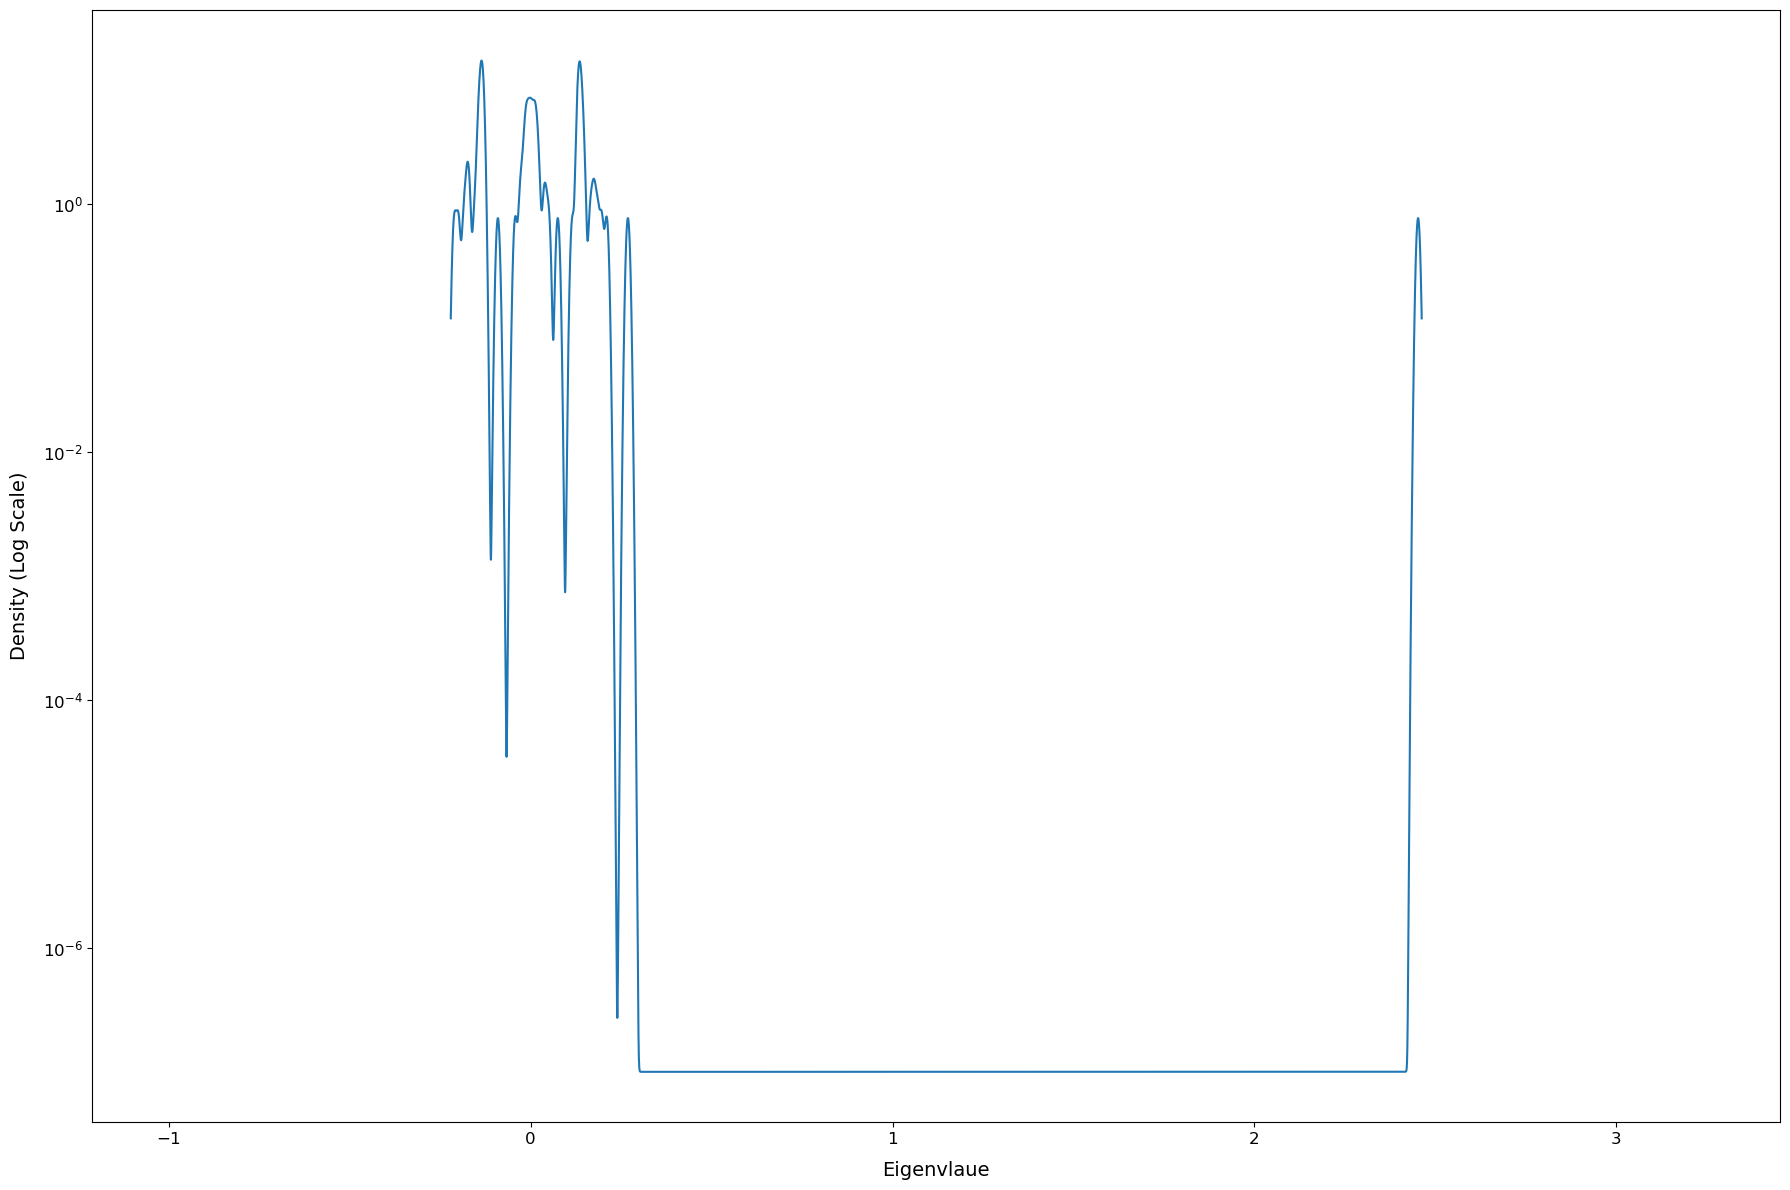

In [34]:
plt.semilogy(grids, density + 1.0e-7)
plt.ylabel('Density (Log Scale)', fontsize=14, labelpad=10)
plt.xlabel('Eigenvlaue', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axis([np.min(density_eigen) - 1, np.max(density_eigen) + 1, None, None])
plt.tight_layout()
plt.show()

## 4. 2D Loss Landscape

In [35]:
def refined_loss(loss):
    return np.log(1.+loss)

In [36]:
# compute loss data
pll = loss_landscapes.PlanarLossLandscape(model_final, STEPS, deepcopy_model=True)
pll.precomputed(dir_one, dir_two, distance=DIST, normalization=NORM, centered=True)
pll.stats_initializer()

In [37]:
# single batch loss landscape
since = time.time()
pll.warm_up(metric)
print('warmup time cost ', time.time()-since)

since = time.time()
loss_data = pll.compute(metric)
print('compute time cost ', time.time()-since)

warmup time cost  20.77347993850708
compute time cost  18.42542004585266


In [38]:
loss_data_fin = refined_loss(loss_data)
loss_data_fin = loss_data

The loss values on this plane can be visualized in an intuitive and interpretable manner using contour plots or 3D surface plots:

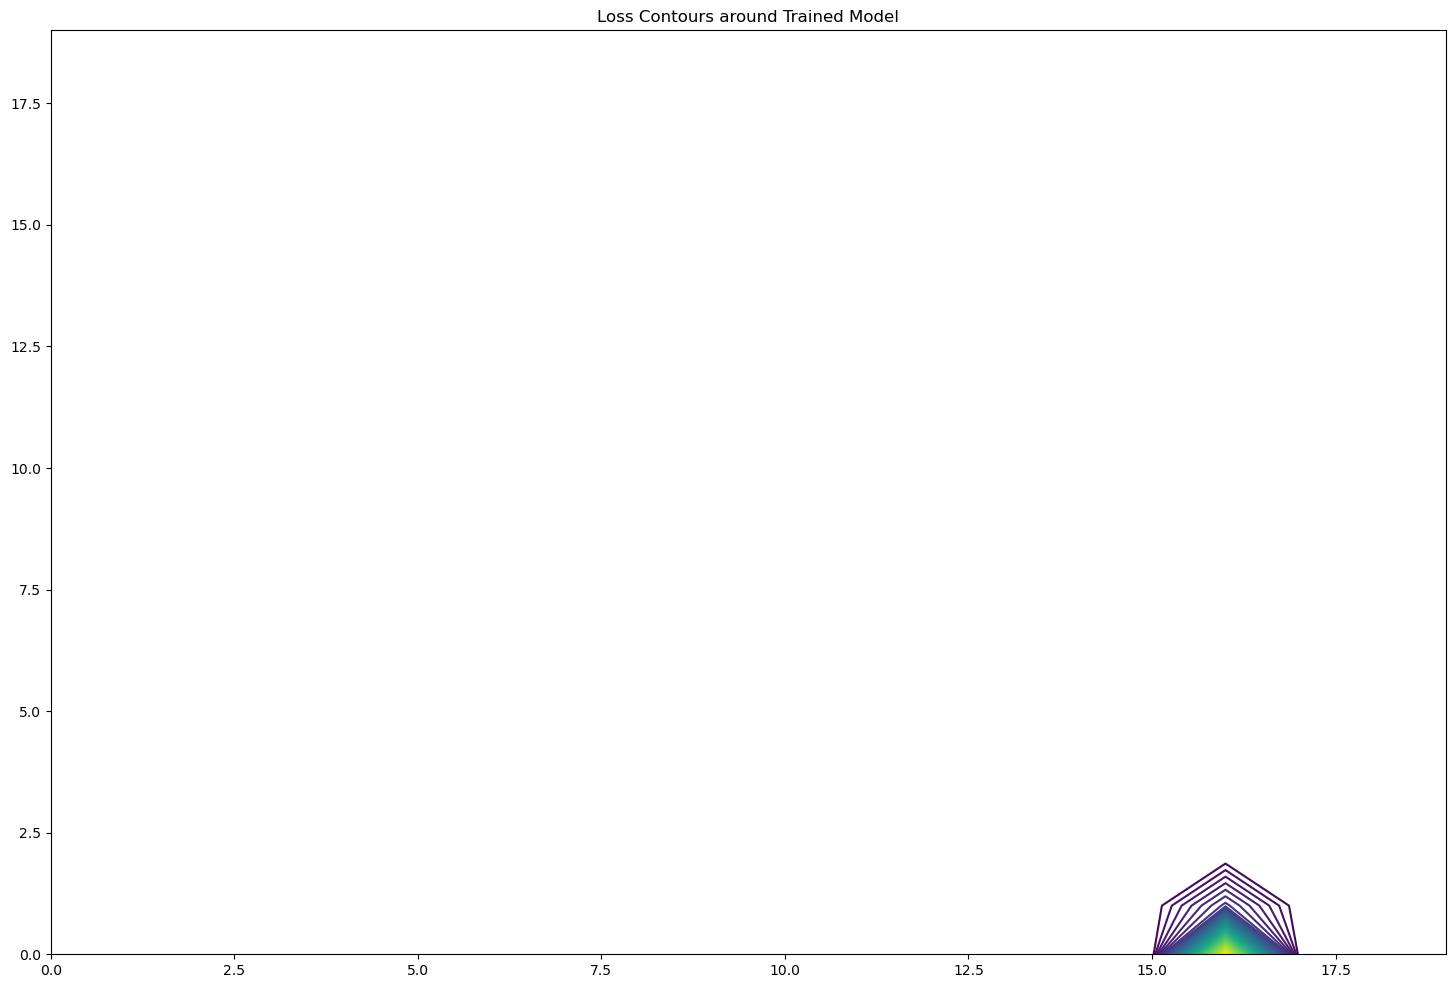

In [39]:
plt.contour(loss_data_fin, levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()

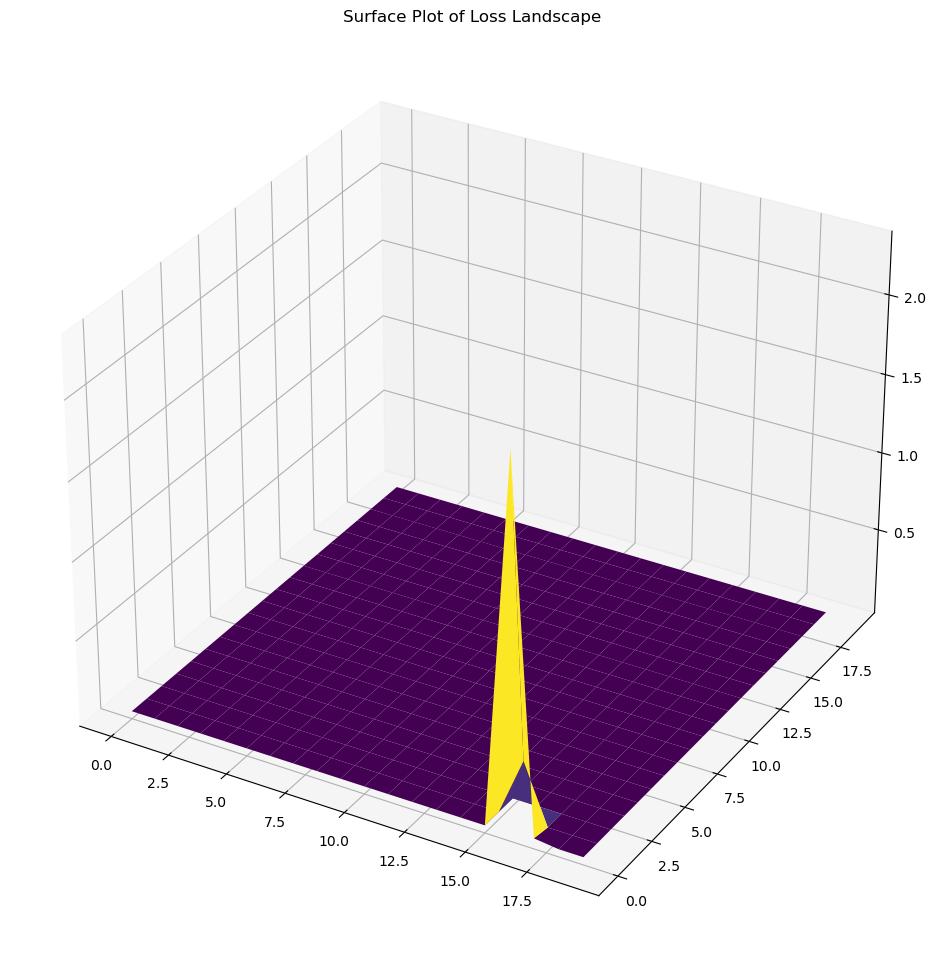

In [40]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()